#### This notebook creates figures for our paper.

Load libraries

In [2]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the knee single-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [4]:
file_name = '/gscratch/fellows/fastmri/reduced/singlecoil_train/file1002567.h5'
#file_name = '/gscratch/fellows/fastmri/knee/multicoil_train/file1002569.h5'
hf = h5py.File(file_name)

In [5]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPD_FBK', 'max': 0.001656625078837613, 'norm': 0.5239231641796293, 'patient_id': 'e9bca71b985419d5d22d0fcc07ff07009e675273b699390ca7dd2de2ffccb8fa'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [102]:
# load kspace example
volume_kspace = hf['kspace'][()]
print("old k-space:", volume_kspace.shape)

if len(volume_kspace.shape) == 3: # singlecoil
    newshape = volume_kspace.shape
    newshape = list(newshape)
    newshape.insert(1, 1)
    newshape = tuple(newshape)
    volume_kspace = volume_kspace.reshape(newshape)
    print("new k-space:", volume_kspace.shape)

# load reconstruction for example
reconstruction_rss = hf['reconstruction_rss'][()]
print("reconstruction:", reconstruction_rss.shape)

old k-space: (45, 640, 368)
new k-space: (45, 1, 640, 368)
reconstruction: (45, 320, 320)


In [101]:
slice_kspace = volume_kspace[0] # Choosing the 0-th slice of this volume so no problem with single or multi-coil

coils = [0, 5, 10] if volume_kspace.shape[1] > 1 else [0]

Let's see what the absolute value of k-space looks like:

In [28]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

(1, 640, 368)


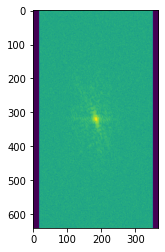

In [29]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), coils)
print(slice_kspace.shape)

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [30]:
import fastmri
from fastmri.data import transforms as T

In [107]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

In [179]:
crop_size = (reconstruction_rss.shape[-2], reconstruction_rss.shape[-1])
print("Crop size:", crop_size)

slices = len(volume_kspace)
slice = len(volume_kspace) // 2
print("Choosing slice", slice, "out of", slices, "slices.")

image = T.to_tensor(volume_kspace)#[slice])
image = fastmri.ifft2c(image)
image = T.complex_center_crop(image, crop_size)
image = fastmri.complex_abs(image)

# normalize input
image, mean, std = T.normalize_instance(image, eps=1e-100)
image = image.clamp(-6, 6)#.squeeze(1)
print(image.shape)

Crop size: (320, 320)
Choosing slice 22 out of 45 slices.
torch.Size([45, 1, 320, 320])


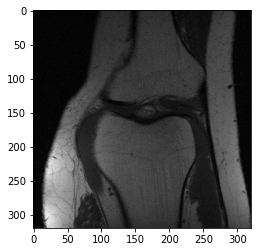

In [180]:
plt.imshow(image.squeeze(1)[15], cmap='gray')

Visualize the layers.

In [181]:
import fastmri
from pathlib import Path

import torch
from fastmri.pl_modules import FastMriDataModule, UnetModule

from captum.attr import GuidedGradCam, GuidedBackprop
from captum.attr import LayerActivation, LayerConductance, LayerGradCam

# load the ckpt
ckpt = torch.load('/gscratch/fellows/npho/fastmri-oms/fastmri_examples/unet/results/unet_demo/checkpoints/epoch=2.ckpt')

# create model and load checkpoint state weights
model = UnetModule()
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [185]:
print( model.unet)

Unet(
  (down_sample_layers): ModuleList(
    (0): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropout2d(p=0.0, inplace=False)
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (6): LeakyReLU(negative_slope=0.2, inplace=True)
        (7): Dropout2d(p=0.0, inplace=False)
      )
    )
    (1): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropout2

In [49]:
# lock in weights
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# captum guided gradcam
ggc = GuidedGradCam(model, conv_module)
ggc_o = ggc.attribute(X_tensor, target=y_tensor)


In [ ]:
def grad_cam(self, X, y, gc_model):
    """
    Input:
    - X: Input image 
    - y: Target image
    - model: A pretrained CNN that will be used to compute the gradcam.
    - slice: slice of the MRI image to visualize
    """
    conv_module = gc_model.features[12] # layer to target
    gradient_value = None  # Stores gradient of the module you chose above during a backwards pass.
    activation_value = None  # Stores the activation of the module you chose above during a forwards pass.

    def gradient_hook(a, b, gradient):
        gradient_value = gradient[0]

    def activation_hook(a, b, activation):
        activation_value = activation

    conv_module.register_forward_hook(activation_hook)
    conv_module.register_backward_hook(gradient_hook)

    cam = []

    # loop through each image
    N, _, _, _ = X_tensor.shape 
    for n in range(N):
        print("GradCAM", n)

        # forward pass
        x = X[n, :, :, :].unsqueeze(0).clone().detach() # (5, 3, 224, 224) -> (1, 3, 224, 224)
        output = gc_model.forward(x) # (1, 1000)

        # backward pass of correct class output scores
        loss = output[0, y[n]]
        loss.backward()

        # average the full kernel of each channel to get alpha weights
        alpha = torch.mean(self.gradient_value, dim=[0, 2, 3]) # (1, 512, 13, 13) -> (512)

        # weight the channels by corresponding gradients
        c = alpha.reshape((1,-1,1,1)) * self.activation_value # (1, 512, 1, 1) * (1, 512, 13, 13)
        c = torch.sum(c, dim=1).squeeze() # (1, 512, 13, 13) -> (1, 13, 13) -> (13, 13)
        c = torch.nn.functional.relu(c) # only '+' influence on input for classification

        cam.append( c.detach().numpy() )

    cam = np.asarray(cam)

    # Rescale GradCam output to fit image.
    cam_scaled = []
    for i in range(cam.shape[0]):
        cam_scaled.append(np.array(Image.fromarray(cam[i]).resize(X_tensor[i, 0, :, :].shape, Image.BICUBIC)))
    cam = np.array(cam_scaled)
    cam -= np.min(cam)
    cam /= np.max(cam)
    return cam

In [ ]:
grad_cam(X, reconstruction_rss, )

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [35]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [36]:
masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [37]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

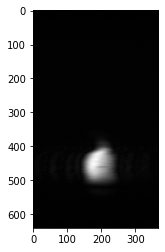

In [38]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')